In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy

In [87]:
class canny_detector():
    def __init__(self,img_path = None,gaussian_size=3,gaussian_sigma=1,highThresholdRatio=0.17,lowThreshold=40,weak_pixel =75, strong_pixel =255,
                                        strides=1, padding='same', verbose=True, title=None, double_thresh=True, threshold_=30):
        self.img_path = img_path
        self.gaussian_size = gaussian_size
        self.sigma = gaussian_sigma
        self.highThresholdRatio = highThresholdRatio
        self.lowThreshold = lowThreshold
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.strides = strides
        self.padding = padding
        self.verbose = verbose
        self.title = title
        self.double_thresh =double_thresh
        self.threshold_ = threshold_

    def convolve(self, img_path, kernel, title = None):
        """
        This function will take an image, a kernel as input and return the image which is filtered by the kernel.
        The kernel should be in square size, for example (3,3), (5,5), (7,7), (9,9)....

        strides is the how much you want to slide your kernel through the image. This function only work with strides = 1 at the moment

        padding is how you want to output to be. If padding = 'same', then the output image will be the same size as the input. 
        """
        if type(img_path)!=str:
            image = img_path
        else:
        # read image
            image = np.array(Image.open(img_path))

        if len(image.shape) ==3:
            image_row, image_col,image_cha = image.shape
        else:
            image_row, image_col =image.shape


        kernel = np.flip(kernel)    # flip the kernel before convolve
        kernel_row, kernel_col = kernel.shape

        # compute how to pad the image correctly
        if self.padding == 'same':
            out_height = int(np.ceil(float(image_row) / float(self.strides)))
            out_width  = int(np.ceil(float(image_col) / float(self.strides)))
        elif self.padding == 'valid':
            out_height = int(np.ceil(float(image_row - kernel_row + 1) / float(self.strides)))
            out_width  = int(np.ceil(float(image_col - kernel_col + 1) / float(self.strides)))
        pad_along_height = max((out_height - 1) * self.strides +
                        kernel_row - image_row, 0)
        pad_along_width = max((out_width - 1) * self.strides +
                        kernel_col - image_col, 0)
        pad_top = int(pad_along_height // 2)
        pad_bottom = int(pad_along_height - pad_top)
        pad_left = int(pad_along_width // 2)
        pad_right = int(pad_along_width - pad_left)
    
        
        #create a empty numpy array to store padded image
        padded_image = np.ndarray(((image_row +(pad_top+pad_bottom)), 
                                (image_col +(pad_left+pad_right)) ),np.int) 

        # pad image 
        padded_image[:,:] = np.pad( image,((pad_top,pad_bottom), (pad_left,pad_right)),'constant')

        # create an output to store the result
        output = np.zeros((out_height, out_width))


        for row in range(image_row):
            for col in range(image_col):
                output[row, col] = (1/(kernel_row * kernel_col)) *np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col]) 

        # retrieve img from numpy array
        output1= Image.fromarray(np.array(np.uint8(output)))  

        if self.verbose:
            plt.imshow(output1, cmap ='gray')
            plt.title("Output Image using {} ".format(title))
            plt.show()
    
        return output


    def gaussian_kernel(self):
        size = self.gaussian_size
        sigma = self.sigma
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g   

    def sobel_detection(self, img):

        # create x_kernel and y_kernel
        sobel_x_kernel =np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        sobel_y_kernel =np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        # convolve the image with kernel 
        dx = self.convolve(img,sobel_x_kernel, title="gradient in x-direction")
        dy = self.convolve(img,sobel_y_kernel, title="gradient in y-direction")
        G = np.sqrt((np.square(dx)+np.square(dy)))
        # G = np.hypot(dx, dy) # compute gradient: sqrt(dx**2 +dy**2)
        G = G / G.max() * 255
        theta = np.arctan(dy, dx) # compute theta
        if self.verbose:
            plt.imshow(G,cmap='gray')
            plt.title("Output Image using sobel filter")
            plt.show()
        return G,theta  

    def non_max_suppression(self,img, theta):
        M, N = img.shape
        # create an output
        Z = np.zeros((M,N), dtype=np.int32)

        # convert theta from radian to degree
        angle = theta * 180. / np.pi
        angle[angle < 0] += 180

        
        for i in range(M):
            for j in range(N):
                try:
                    q = 255
                    r = 255
                    
                #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = img[i, j+1]
                        r = img[i, j-1]
                    #angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        q = img[i+1, j-1]
                        r = img[i-1, j+1]
                    #angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        q = img[i+1, j]
                        r = img[i-1, j]
                    #angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        q = img[i-1, j-1]
                        r = img[i+1, j+1]

                    if (img[i,j] >= q) and (img[i,j] >= r):
                        Z[i,j] = img[i,j]
                    else:
                        Z[i,j] = 0

                except:
                    pass
        if self.verbose:
            plt.imshow(Z,cmap='gray')
            plt.title("Output Image using non maximum supression ")
            plt.show()        
        return Z

    def double_threshold(self, img):
        
        highThreshold = img.max() * self.highThresholdRatio
        lowThreshold =  self.lowThreshold
        
        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)
        
        weak = self.weak_pixel
        strong = self.strong_pixel
        
        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)
        
        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
        
        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak
        if self.verbose:
            plt.imshow(res,cmap='gray')
            plt.title("Output Image using double thresholding ")
            plt.show()   
        
        return res
    def edge_hysteresis(self, img):
        M, N = img.shape  
        weak = self.weak_pixel
        strong = self.strong_pixel
        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError as e:
                        pass
        if self.verbose:
            plt.imshow(img,cmap='gray')
            plt.title("Output Image using hysteresis ")
            plt.show()                           
        return img
    def normal_threshold(self,img):
        threshold_ = self.threshold_
        img_thres = copy.copy(img)
        img_thres[img < threshold_] = 0
        img_thres[img_thres[:]!=0]=255
        if self.verbose:
            plt.imshow(img_thres, cmap ='gray')
            plt.title("Output Image using normal threshold={}".format(threshold_))
            plt.show()
    def detect_edge(self):
        smooth = self.convolve(self.img_path,self.gaussian_kernel(), title ="Gaussian smooth")
        after_sobel, theta = self.sobel_detection(smooth)
        after_nms = self.non_max_suppression(after_sobel, theta)
        if self.double_thresh:
            thresholding = self.double_threshold(after_nms)
            result = self.edge_hysteresis(thresholding)
        else:
            result = self.normal_threshold(after_nms)
        return result




In [95]:
img_path = "C:/Users/default.DESKTOP-IU77C8K/OneDrive - jbnu.ac.kr/uni_D/first sem/computer science/lab2/horse.jpg"
canny = canny_detector(img_path=img_path,highThresholdRatio=0.18,lowThreshold=40, double_thresh=False, threshold_= 45,gaussian_size=5,gaussian_sigma=1.4 )


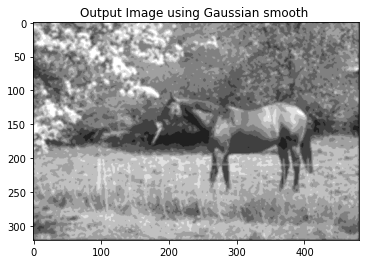

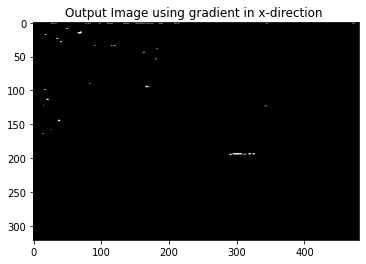

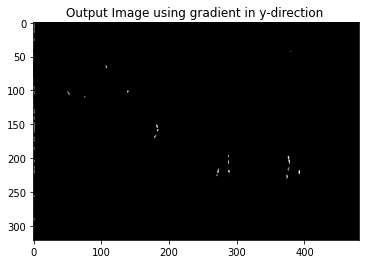

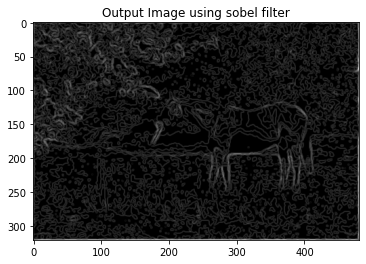

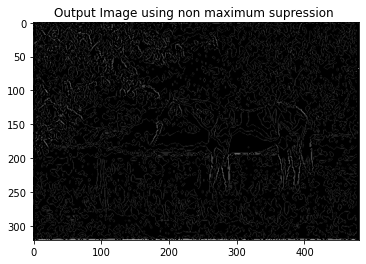

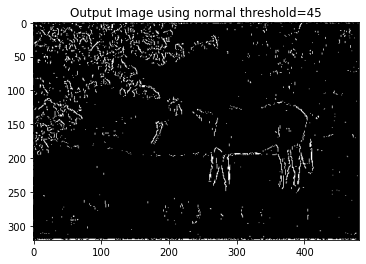

In [96]:
canny.detect_edge()

In [2]:
def filtering(img_path, kernel, strides=1, padding='same', verbose=False, title=""):

    """
    This function will take an image, a kernel as input and return the image which is filtered by the kernel.
    The kernel should be in square size, for example (3,3), (5,5), (7,7), (9,9)....

    strides is the how much you want to slide your kernel through the image. This function only work with strides = 1 at the moment

    padding is how you want to output to be. If padding = 'same', then the output image will be the same size as the input. 
    """
    if type(img_path)!=str:
        image = img_path
    else:
    # read image
        image = np.array(Image.open(img_path))

    if len(image.shape) ==3:
        image_row, image_col,image_cha = image.shape
    else:
        image_row, image_col =image.shape


    kernel = np.flip(kernel)    # flip the kernel before convolve
    kernel_row, kernel_col = kernel.shape

    # compute how to pad the image correctly
    if padding == 'same':
        out_height = int(np.ceil(float(image_row) / float(strides)))
        out_width  = int(np.ceil(float(image_col) / float(strides)))
    elif padding == 'valid':
        out_height = int(np.ceil(float(image_row - kernel_row + 1) / float(strides)))
        out_width  = int(np.ceil(float(image_col - kernel_col + 1) / float(strides)))
    pad_along_height = max((out_height - 1) * strides +
                    kernel_row - image_row, 0)
    pad_along_width = max((out_width - 1) * strides +
                    kernel_col - image_col, 0)
    pad_top = int(pad_along_height // 2)
    pad_bottom = int(pad_along_height - pad_top)
    pad_left = int(pad_along_width // 2)
    pad_right = int(pad_along_width - pad_left)
 
    
    #create a empty numpy array to store padded image
    padded_image = np.ndarray(((image_row +(pad_top+pad_bottom)), 
                            (image_col +(pad_left+pad_right)) ),np.int) 

    # pad image 
    padded_image[:,:] = np.pad( image,((pad_top,pad_bottom), (pad_left,pad_right)),'constant')

    # create an output to store the result
    output = np.zeros((out_height, out_width))


    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = (1/(kernel_row * kernel_col)) *np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col]) 

    # retrieve img from numpy array
    output1= Image.fromarray(np.array(np.uint8(output)))  

    if verbose:
        plt.imshow(output1, cmap ='gray')
        plt.title("Output Image using {} ".format(title))
        plt.show()
 
    return (output)

In [8]:
img_path = "C:/Users/default.DESKTOP-IU77C8K/OneDrive - jbnu.ac.kr/uni_D/first sem/computer science/lab2/mountain.jpg"

In [4]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

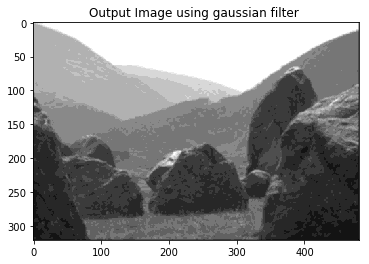

In [105]:
after_gaussian=filtering(img_path,gaussian_kernel(3,1.5),verbose=True,title="gaussian filter")

In [5]:
def sobel_detection(img_path):

    # create x_kernel and y_kernel
    sobel_x_kernel =np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    sobel_y_kernel =np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    # convolve the image with kernel 
    dx = filtering(img_path,sobel_x_kernel,verbose=True, title="gradient in x-direction")
    dy = filtering(img_path,sobel_y_kernel,verbose=True, title="gradient in y-direction")
    G = np.sqrt((np.square(dx)+np.square(dy)))
    # G = np.hypot(dx, dy) # compute gradient: sqrt(dx**2 +dy**2)
    G = G / G.max() * 255
    theta = np.arctan(dy, dx) # compute theta
    plt.imshow(G,cmap='gray')
    plt.title("Output Image using {} ".format("gradient output image:  "))
    plt.show()
    return G,theta


In [341]:
def prewitt_detection(img_path):
    
    # create x_kernel and y_kernel
    prewitt_x_kernel =np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewitt_y_kernel =np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    # convolve the image with kernel 
    dx = filtering(img_path,prewitt_x_kernel,verbose=True, title="gradient in x-direction")
    dy = filtering(img_path,prewitt_y_kernel,verbose=True, title="gradient in y-direction")

    G = np.hypot(dx, dy) # compute gradient: sqrt(dx**2 +dy**2)
    G = G / G.max() * 255
   
    plt.imshow(G,cmap='gray')
    plt.title("Output Image using {} ".format("gradient output image:  "))
    plt.show()
    return G

In [9]:
def non_max_suppression(img, theta):
    M, N = img.shape
    # create an output
    Z = np.zeros((M,N), dtype=np.int32)

    # convert theta from radian to degree
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(M):
        for j in range(N):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except:
                pass
    
    return Z

In [10]:
def double_threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.17):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(75)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [11]:
def edge_hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [536]:
def normal_threshold(img, threshold):
    img_thres = img.copy()
    img_thres[img < threshold] = 0
    img_thres[img_thres[:]!=0]=255
    print("after thresholding: ")
    plt.imshow(img_thres, cmap ='gray')
    plt.title("Output Image using threshold={}".format(threshold))
    plt.show()

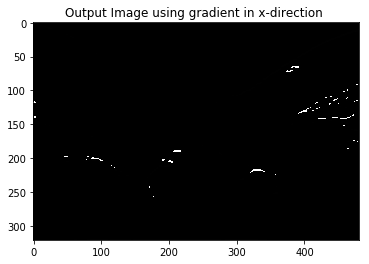

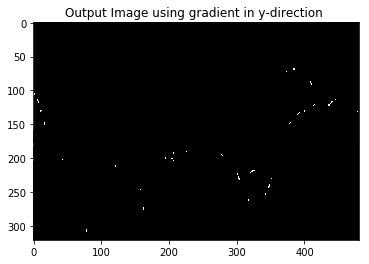

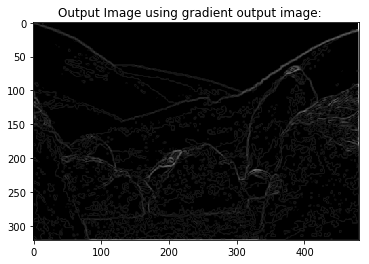

In [106]:
img,theta = sobel_detection(after_gaussian)


In [107]:
after_nms = non_max_suppression(img,theta)

&lt;matplotlib.image.AxesImage at 0x282e02e52b0&gt;

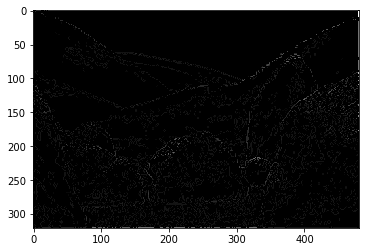

In [108]:
plt.imshow(after_nms,cmap='gray')

&lt;matplotlib.image.AxesImage at 0x282dfd76f60&gt;

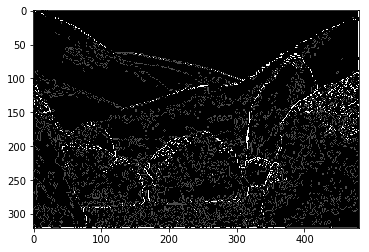

In [115]:
result,weak,strong=threshold2(after_nms,0.05,0.11)
plt.imshow(result,cmap='gray')

&lt;matplotlib.image.AxesImage at 0x282dfd92710&gt;

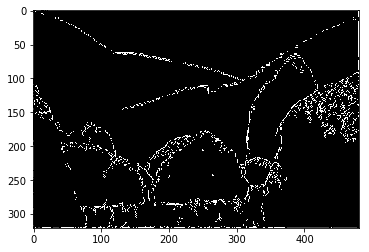

In [116]:

res = hysteresis(result,weak=weak,strong=strong)
plt.imshow(res,cmap='gray')

In [28]:
plt.imsave("D:/uni/first sem/computer science/lab2/edge.jpg",res,cmap='gray')

&lt;matplotlib.image.AxesImage at 0x208a4cf8198&gt;

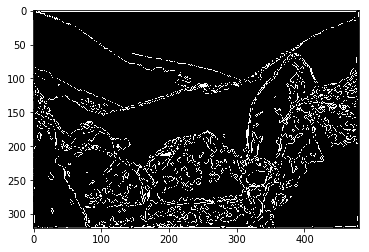

In [629]:
plt.imshow(result,cmap='gray')

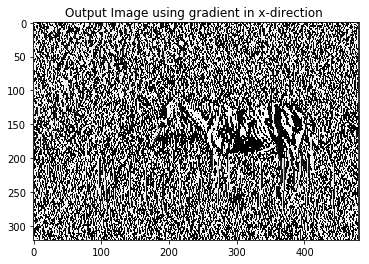

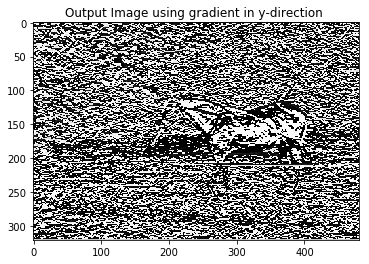

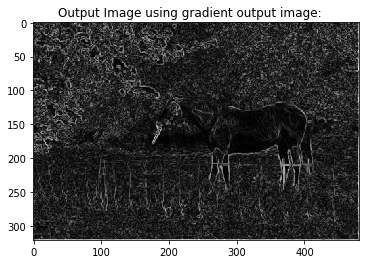

In [342]:
img = prewitt_detection(img_path)


after thresholding: 


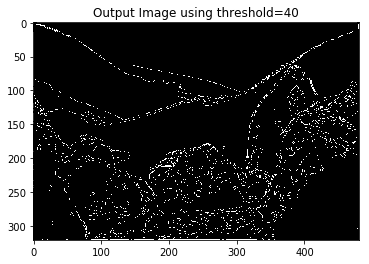

In [630]:
threshold(after_nms,40)